# 第一次作业

在3.1和3.2小节的基础上，探究网络层数、隐藏层神经元个数和激活函数对网络在MNIST数据集上的性能的影响。

1. 将网络层数调整为{1,2,3,4,5}，观察模型在训练集和测试集上的损失函数/准确率的变化。
1. 固定网络层数为2，将隐藏层神经元个数调整为{1,4,16,64}，观察模型在训练集和测试集上的损失函数/准确率的变化。
1. 固定网络层数为2，去掉网络中的激活函数，观察模型在训练集和测试集上的损失函数/准确率。
1. 对于上述的现象，我们能解释其发生的原因吗？

### 第一小题

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

d:\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# 下载MNIST数据集中的训练集，并保存到data文件夹
data_train = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
# 加载MNIST数据集中的测试集
data_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

9913344it [00:00, 14791523.28it/s]                             


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



29696it [00:00, 4034923.44it/s]          


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



1649664it [00:00, 4274766.31it/s]                            


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



5120it [00:00, ?it/s]                   

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw




d:\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
type(data_train)

torchvision.datasets.mnist.MNIST

In [5]:
img, label = data_train[0] # 取出第一个数据（第一张图片）
img.size() 

torch.Size([1, 28, 28])

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [63]:
# 定义MLP网络，更改层数{1,2,3,4,5}

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(MLP, self).__init__()
        self.in_features = in_features
        self.layer1 = nn.Linear(in_features, hidden_features) # 此处的nn.Linear是PyTorch里定义的线性层
        self.layer2 = nn.Linear(hidden_features, hidden_features)
        self.layer3 = nn.Linear(hidden_features, hidden_features)
        self.layer4 = nn.Linear(hidden_features, hidden_features)
        self.layer5 = nn.Linear(hidden_features, out_features)
        
    def forward(self, x):
        x = x.view(-1, self.in_features) # 将每张图片转换成向量
        x = self.layer1(x)
        x = F.relu(x) # 非线性激活层，ReLU函数
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        x = F.relu(x)
        x = self.layer5(x)
        return x

In [97]:
# 我们定义一个train函数来封装我们的训练过程
def train(model, data, num_epochs=15, learning_rate=1e-3, batch_size=32):
    # 定义一个优化器，Adam优化器是梯度下降法的一个变种
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # weight_decay表示L2正则项
    
    # 把训练数据封装到DataLoader，这样便于我们以及选取batch以及打乱数据顺序
    train_loader = torch.utils.data.DataLoader(data, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    # 定义损失函数（里面包含了softmax操作）
    criterion = nn.CrossEntropyLoss()

    # 记录每个epoch的loss，为了后面画图
    loss_list=[]
    
    for epoch in range(num_epochs):
        loss_total = 0 # 定义一个loss_total变量来记录我们的loss变化
        for data in train_loader:
            # 梯度清零
            optimizer.zero_grad()
            
            img, label = data
            img = img.to(device)
            label = label.to(device)
            
            # 前向传播和反向传播 
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            
            # 优化参数
            optimizer.step()

        loss_total += loss.item() 
        loss_list.append(loss_total)
        print('Epoch: {}, Training Loss: {:.4f}'.format(epoch+1, loss_total))

    return loss_list


In [42]:
@torch.no_grad() # 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
def test(model, data, batch_size=128):
    num_correct = 0 # 预测正确的图片数
    num_total = 0 # 总共的图片数
    
    test_loader = torch.utils.data.DataLoader(data, 
                                              batch_size=batch_size, 
                                              shuffle=False)
    for data in test_loader: # 按batch取出测试集中的数据
        img, label = data
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        predicted = output.argmax(1)
        num_total += len(label)
        num_correct += (predicted == label).sum()

    print('共有{}张图片，准确率为: {:.2f}%'.format(num_correct, 100 * num_correct / num_total))    

    return num_correct / num_total

In [43]:
img, label = data_train[0]
img = img.view(-1)  # view(-1)表示把矩阵变成一维向量: (1,28,28) --> (784,)
feat_dim = len(img) # 计算输入的特征的维度（图片的维度）
num_classes = 10
feat_dim, num_classes

(784, 10)

In [64]:
model = MLP(in_features=feat_dim, hidden_features=256, out_features=num_classes)
model = model.to(device)
model

MLP(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=256, bias=True)
  (layer5): Linear(in_features=256, out_features=10, bias=True)
)

In [45]:
loss_1layer = train(model, data_train)

Epoch: 1, Training Loss: 0.3969
Epoch: 2, Training Loss: 0.3533
Epoch: 3, Training Loss: 0.4258
Epoch: 4, Training Loss: 0.6783
Epoch: 5, Training Loss: 0.1624
Epoch: 6, Training Loss: 0.1409
Epoch: 7, Training Loss: 0.3243
Epoch: 8, Training Loss: 0.1403
Epoch: 9, Training Loss: 0.0718
Epoch: 10, Training Loss: 0.1440


In [48]:
score1 = test(model, data_train)
score2 = test(model, data_test)
score_1layer = [score1, score2]

共有55961张图片，准确率为: 93.27%
共有9274张图片，准确率为: 92.74%


In [50]:
score_1layer

[tensor(0.9327), tensor(0.9274)]

In [53]:
loss_2layer = train(model, data_train)

Epoch: 1, Training Loss: 0.1258
Epoch: 2, Training Loss: 0.0413
Epoch: 3, Training Loss: 0.0134
Epoch: 4, Training Loss: 0.0074
Epoch: 5, Training Loss: 0.0046
Epoch: 6, Training Loss: 0.0040
Epoch: 7, Training Loss: 0.0601
Epoch: 8, Training Loss: 0.0486
Epoch: 9, Training Loss: 0.0027
Epoch: 10, Training Loss: 0.0891


In [54]:
score1 = test(model, data_train)
score2 = test(model, data_test)
score_2layer = [score1, score2]

共有59867张图片，准确率为: 99.78%
共有9799张图片，准确率为: 97.99%


In [57]:
loss_3layer = train(model, data_train)

Epoch: 1, Training Loss: 0.2695
Epoch: 2, Training Loss: 0.0305
Epoch: 3, Training Loss: 0.0519
Epoch: 4, Training Loss: 0.0089
Epoch: 5, Training Loss: 0.0020
Epoch: 6, Training Loss: 0.0148
Epoch: 7, Training Loss: 0.0076
Epoch: 8, Training Loss: 0.0004
Epoch: 9, Training Loss: 0.0488
Epoch: 10, Training Loss: 0.0001


In [58]:
score1 = test(model, data_train)
score2 = test(model, data_test)
score_3layer = [score1, score2]

共有59666张图片，准确率为: 99.44%
共有9803张图片，准确率为: 98.03%


In [61]:
loss_4layer = train(model, data_train)

Epoch: 1, Training Loss: 0.2092
Epoch: 2, Training Loss: 0.0009
Epoch: 3, Training Loss: 0.0029
Epoch: 4, Training Loss: 0.0146
Epoch: 5, Training Loss: 0.0011
Epoch: 6, Training Loss: 0.1515
Epoch: 7, Training Loss: 0.0847
Epoch: 8, Training Loss: 0.0004
Epoch: 9, Training Loss: 0.0065
Epoch: 10, Training Loss: 0.0193


In [62]:
score1 = test(model, data_train)
score2 = test(model, data_test)
score_4layer = [score1, score2]

共有59544张图片，准确率为: 99.24%
共有9760张图片，准确率为: 97.60%


In [65]:
loss_5layer = train(model, data_train)

Epoch: 1, Training Loss: 0.1055
Epoch: 2, Training Loss: 0.1338
Epoch: 3, Training Loss: 0.0531
Epoch: 4, Training Loss: 0.0312
Epoch: 5, Training Loss: 0.0022
Epoch: 6, Training Loss: 0.0038
Epoch: 7, Training Loss: 0.1863
Epoch: 8, Training Loss: 0.0157
Epoch: 9, Training Loss: 0.0064
Epoch: 10, Training Loss: 0.0068


In [66]:
score1 = test(model, data_train)
score2 = test(model, data_test)
score_5layer = [score1, score2]

共有59676张图片，准确率为: 99.46%
共有9796张图片，准确率为: 97.96%


#### 画图进行分析

In [87]:
import matplotlib.pyplot as plt
import numpy as np

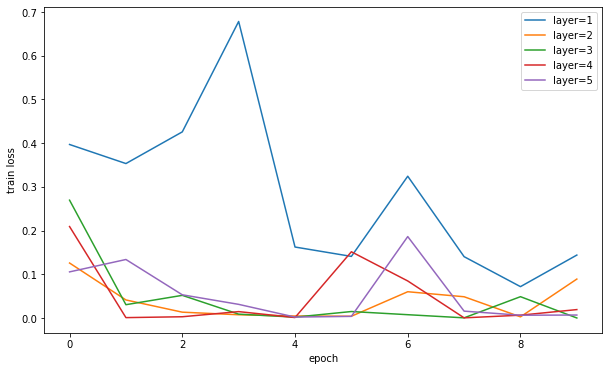

In [72]:
x = [i for i in range(10)]
plt.figure(figsize=(10,6))
plt.plot(x, loss_1layer)
plt.plot(x, loss_2layer)
plt.plot(x, loss_3layer)
plt.plot(x, loss_4layer)
plt.plot(x, loss_5layer)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.legend(["layer=1","layer=2","layer=3","layer=4","layer=5"])
plt.show()

调整网络层数为{1,2,3,4,5}，图中折线图画出了模型的训练误差随epoch变化的图像。
误差都呈现震荡下降的趋势。
layer=1时的误差明显高于其他四种情况，猜测原因是layer=1时只有一个线性层、没有激活函数，模型过于简单导致拟合能力差。

In [76]:
train_score = [score_1layer[0],score_2layer[0],score_3layer[0],score_4layer[0],score_5layer[0]]
test_score = [score_1layer[1],score_2layer[1],score_3layer[1],score_4layer[1],score_5layer[1]]

In [77]:
train_score, test_score

([tensor(0.9327),
  tensor(0.9978),
  tensor(0.9944),
  tensor(0.9924),
  tensor(0.9946)],
 [tensor(0.9274),
  tensor(0.9799),
  tensor(0.9803),
  tensor(0.9760),
  tensor(0.9796)])

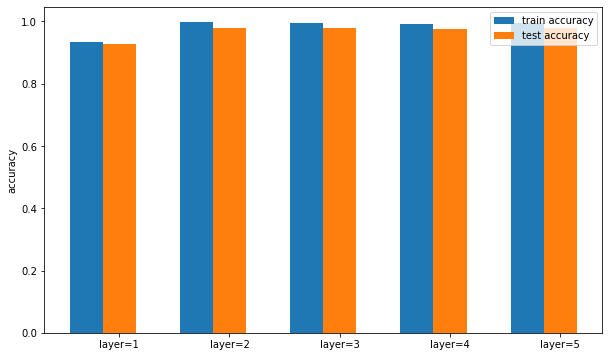

In [92]:
bar_width = 0.3

plt.figure(figsize=(10,6))
x = np.arange(5)
x_label = ["layer=1", "layer=2", "layer=3", "layer=4", "layer=5"]
plt.bar(x, train_score, width=bar_width, tick_label=x_label, label="train accuracy")
plt.bar(x+bar_width, test_score, width=bar_width, tick_label=x_label, label="test accuracy")

plt.legend()
plt.ylabel("accuracy")
plt.show()

从图中可以看出，无论层数多少，每个模型在训练集和测试集上都获得了较高的准确率。每个模型的测试集准确率都略低于训练集准确率，但相差不多，说明模型泛化性能比较不错。

### 第二小题

In [94]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(MLP, self).__init__()
        self.in_features = in_features
        self.layer1 = nn.Linear(in_features, hidden_features) # 此处的nn.Linear是PyTorch里定义的线性层
        self.layer2 = nn.Linear(hidden_features, out_features)
        
    def forward(self, x):
        x = x.view(-1, self.in_features) # 将每张图片转换成向量
        x = self.layer1(x)
        x = F.relu(x) # 非线性激活层，ReLU函数
        x = self.layer2(x)
        return x

In [98]:
a = [1,4,16,64]
train_loss_list = []
train_score_list = []
test_score_list = []

for hidden in a:

    print(hidden)

    model = MLP(in_features=feat_dim, hidden_features=hidden, out_features=num_classes)
    model = model.to(device)
    print(model)

    train_loss = train(model, data_train)
    train_loss_list.append(train_loss)

    score1 = test(model, data_train)
    train_score_list.append(score1)
    score2 = test(model, data_test)
    test_score_list.append(score2)

    print("\n")

1
MLP(
  (layer1): Linear(in_features=784, out_features=1, bias=True)
  (layer2): Linear(in_features=1, out_features=10, bias=True)
)
Epoch: 1, Training Loss: 1.8026
Epoch: 2, Training Loss: 1.8064
Epoch: 3, Training Loss: 1.7415
Epoch: 4, Training Loss: 1.7899
Epoch: 5, Training Loss: 1.8094
Epoch: 6, Training Loss: 2.0438
Epoch: 7, Training Loss: 1.6018
Epoch: 8, Training Loss: 1.6455
Epoch: 9, Training Loss: 1.7434
Epoch: 10, Training Loss: 1.7960
Epoch: 11, Training Loss: 1.5173
Epoch: 12, Training Loss: 1.8171
Epoch: 13, Training Loss: 1.5716
Epoch: 14, Training Loss: 1.5973
Epoch: 15, Training Loss: 1.5123
共有21567张图片，准确率为: 35.94%
共有3662张图片，准确率为: 36.62%


4
MLP(
  (layer1): Linear(in_features=784, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=10, bias=True)
)
Epoch: 1, Training Loss: 1.2001
Epoch: 2, Training Loss: 0.5865
Epoch: 3, Training Loss: 1.0018
Epoch: 4, Training Loss: 0.4950
Epoch: 5, Training Loss: 0.6548
Epoch: 6, Training Loss: 0.4938
Epoch

In [102]:
train_score_list

[tensor(0.3595), tensor(0.8687), tensor(0.9679), tensor(0.9941)]

In [103]:
test_score_list

[tensor(0.3662), tensor(0.8694), tensor(0.9580), tensor(0.9747)]

In [104]:
train_loss_list

[[1.802565097808838,
  1.8063628673553467,
  1.7415060997009277,
  1.7898849248886108,
  1.8094300031661987,
  2.043771743774414,
  1.6018131971359253,
  1.6455224752426147,
  1.7434293031692505,
  1.7959649562835693,
  1.5173301696777344,
  1.8171025514602661,
  1.5715969800949097,
  1.5972899198532104,
  1.5122909545898438],
 [1.2001456022262573,
  0.586456298828125,
  1.0018314123153687,
  0.4949749708175659,
  0.6548454761505127,
  0.493830144405365,
  0.33014363050460815,
  0.23298677802085876,
  0.3717491924762726,
  0.3423231244087219,
  0.45161280035972595,
  0.3413734436035156,
  0.25979703664779663,
  0.42481178045272827,
  0.22060759365558624],
 [0.22790269553661346,
  0.3589158356189728,
  0.30048197507858276,
  0.04876268282532692,
  0.04035449028015137,
  0.05231915041804314,
  0.11764594912528992,
  0.05969787389039993,
  0.15297457575798035,
  0.0470503531396389,
  0.3944111764431,
  0.0324556902050972,
  0.08853219449520111,
  0.08551889657974243,
  0.2825019359588623]

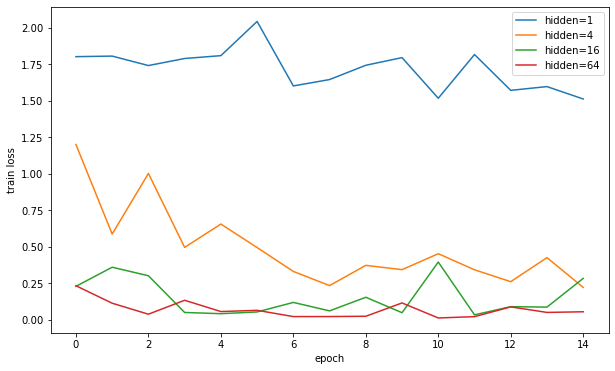

In [109]:
x = [i for i in range(15)]
plt.figure(figsize=(10,6))
plt.plot(x, train_loss_list[0])
plt.plot(x, train_loss_list[1])
plt.plot(x, train_loss_list[2])
plt.plot(x, train_loss_list[3])
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.legend(["hidden=1","hidden=4","hidden=16","hidden=64"])
plt.show()

这张折线图展示了训练误差在不同数量隐藏神经元下随epoch变化。可以看出，当hidden=1时训练效果比较差，可能是隐藏神经元只有一个表达力薄弱。其余四种情况训练误差都呈现震荡下降的趋势，且hidden越大，损失函数越小，发现适当增加隐藏神经元数量有利于模型捕捉信息。

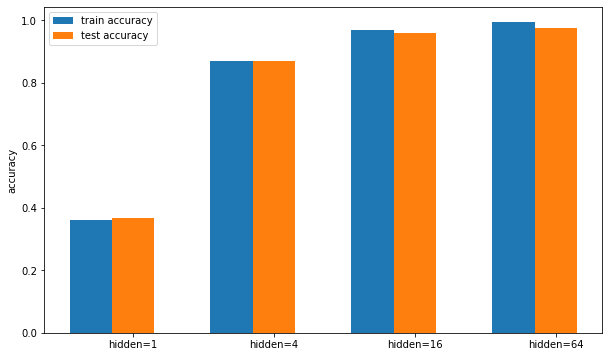

In [110]:
bar_width = 0.3

plt.figure(figsize=(10,6))
x = np.arange(4)
x_label = ["hidden=1","hidden=4","hidden=16","hidden=64"]
plt.bar(x, train_score_list, width=bar_width, tick_label=x_label, label="train accuracy")
plt.bar(x+bar_width, test_score_list, width=bar_width, tick_label=x_label, label="test accuracy")

plt.legend()
plt.ylabel("accuracy")
plt.show()

这张柱状图展示了不同隐藏神经元数目下模型在训练集和测试集上分别取得的准确率。可以看出，当hidden=1时，准确率最低，说明此时模型的学习能力比较欠缺。其余三种情况，准确率随着hidden数量上升而上升，且每种情况下测试集准确率都略低于训练集准确率，说明模型的泛化能力还不错。

### 第三小题

In [101]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(MLP, self).__init__()
        self.in_features = in_features
        self.layer1 = nn.Linear(in_features, hidden_features) # 此处的nn.Linear是PyTorch里定义的线性层
        self.layer2 = nn.Linear(hidden_features, out_features)
        
    def forward(self, x):
        x = x.view(-1, self.in_features) # 将每张图片转换成向量
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [105]:
hidden = 64
model = MLP(in_features=feat_dim, hidden_features=hidden, out_features=num_classes)
model = model.to(device)
print(model)

MLP(
  (layer1): Linear(in_features=784, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=10, bias=True)
)


In [106]:
train_loss_norelu = train(model, data_train)

train_score_norelu = test(model, data_train)
test_score_norelu = test(model, data_test)

Epoch: 1, Training Loss: 0.4224
Epoch: 2, Training Loss: 0.5624
Epoch: 3, Training Loss: 0.0830
Epoch: 4, Training Loss: 0.2119
Epoch: 5, Training Loss: 0.1327
Epoch: 6, Training Loss: 0.3632
Epoch: 7, Training Loss: 0.5119
Epoch: 8, Training Loss: 0.2342
Epoch: 9, Training Loss: 0.2825
Epoch: 10, Training Loss: 0.1132
Epoch: 11, Training Loss: 0.0929
Epoch: 12, Training Loss: 0.1753
Epoch: 13, Training Loss: 0.2910
Epoch: 14, Training Loss: 0.1645
Epoch: 15, Training Loss: 0.0419
共有55734张图片，准确率为: 92.89%
共有9214张图片，准确率为: 92.14%


In [107]:
train_loss_norelu

[0.42241066694259644,
 0.5623505711555481,
 0.0829857587814331,
 0.21190997958183289,
 0.132684588432312,
 0.36317694187164307,
 0.5118504166603088,
 0.23415541648864746,
 0.28246593475341797,
 0.11323849856853485,
 0.09292437881231308,
 0.17529678344726562,
 0.29102814197540283,
 0.16450980305671692,
 0.04193606227636337]

In [108]:
train_score_norelu, test_score_norelu

(tensor(0.9289), tensor(0.9214))

In [111]:
train_loss_withrelu = train_loss_list[3]
train_score_withrelu = train_score_list[3]
test_score_withrelu = test_score_list[3]

In [112]:
train_loss_withrelu

[0.23210535943508148,
 0.11214885860681534,
 0.03697166219353676,
 0.1324462741613388,
 0.05503406003117561,
 0.06345946341753006,
 0.020614134147763252,
 0.020768560469150543,
 0.022745372727513313,
 0.114067442715168,
 0.011015743017196655,
 0.020100630819797516,
 0.08705437183380127,
 0.04914729669690132,
 0.05354964733123779]

In [114]:
train_score_withrelu, test_score_withrelu

(tensor(0.9941), tensor(0.9747))

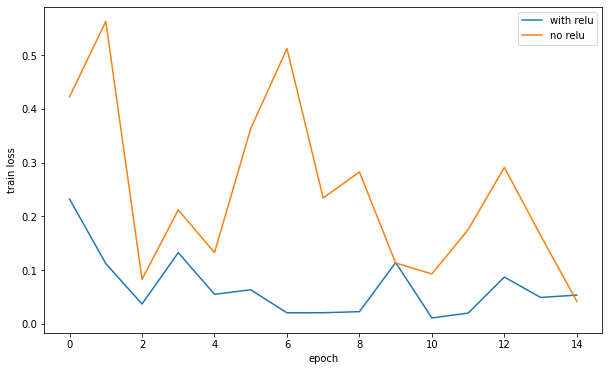

In [115]:
x = [i for i in range(15)]
plt.figure(figsize=(10,6))
plt.plot(x, train_loss_withrelu)
plt.plot(x, train_loss_norelu)

plt.xlabel("epoch")
plt.ylabel("train loss")
plt.legend(["with relu", "no relu"])
plt.show()

从这张折线图可以看出，在没有激活函数时，损失函数仍然呈震荡下降的趋势，但整体要高于有损失函数的情况，且震荡更为剧烈。

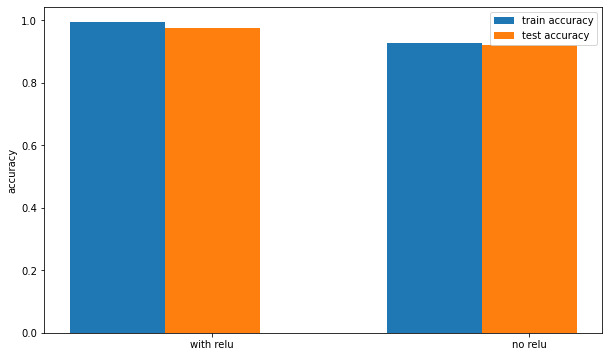

In [116]:
bar_width = 0.3

plt.figure(figsize=(10,6))
x = np.arange(2)
x_label = ["with relu", "no relu"]
plt.bar(x, [train_score_withrelu, train_score_norelu], width=bar_width, tick_label=x_label, label="train accuracy")
plt.bar(x+bar_width, [test_score_withrelu, test_score_norelu], width=bar_width, tick_label=x_label, label="test accuracy")

plt.legend()
plt.ylabel("accuracy")
plt.show()

从这张柱状图可以看出，没有激活函数时的准确率都要低于有激活函数时，说明增加激活函数可以增加模型的表达能力，更好地捕捉数据特征，达到更好的训练效果。